# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** first_name_1 last_name_1, first_name_2 last_name_2, first_name_3 last_name_3  
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

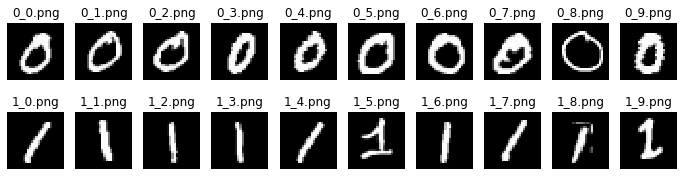

In [3]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

In [4]:
import numpy as np
from scipy.optimize import curve_fit
import cv2
from sklearn.cluster import KMeans, SpectralClustering
from scipy import ndimage
from sklearn.mixture import GaussianMixture
from skimage import measure

from skimage.transform import SimilarityTransform
from skimage.transform import warp

### 1.2 Fourier descriptors

#### At first, we are going to define functions used to preprocess the image with a low-pass filter and to compute the complex contour.

In [5]:
images = np.append(zeros_im,ones_im,axis = 0)

In [6]:
def low_pass_filter(img,size):
    '''
    Low-pass filter applied to the simple images in order to get rid of noise.
    
    Input: grayscale image
    Output: filtered image
    
    '''
    Kernel = np.ones((size,size),np.float32)/size**2
    return ndimage.filters.convolve(img, Kernel)

The low-pass filter is designed to avoid increasing the energy of the preprocessed image.

In [7]:
def get_ordered_contour(im):
    '''
    Contour detection function based on the simple images we have.
    
    Input: grayscale image
    Output: contour of the main feature ( In our application, handwritten digits )
    
    '''
    im = im = low_pass_filter(im,3)
    contours = measure.find_contours(im, 50)
    contours_array = []
    for n, contour in enumerate(contours):
        for x,y in contour:
            contours_array.append((x,y))
    contours_array = np.array(contours_array).astype(int)
        
    return contours_array

#### Create the complex number from the detected contour:   $ u_k = x_k + j*y_k $

In [8]:
def complex_contour_vector(img):
    '''
    Compute the complex contour out of a contour which type is a np array
    
    Input: np array containing the contour coordinates
    Output: Complex contour and a binary contour image 
    
    '''
    contour_array = get_ordered_contour(img)
    contour_img = np.zeros(img.shape)
    uk = []
    
    for k in contour_array:
        uk.append(np.vectorize(complex)(k[0],k[1]))
        contour_img[k[0],k[1]] = 1
    uk = np.array(uk)
    
    return uk, contour_img

#### Compute and plot DFT (FFT) : 

In [9]:
def dft_computation(img,n_descriptor, first_descriptor):
    '''
    Compute the selected fourier descriptors
    
    Input: grayscale image, the number of requested fourier descriptors and the first fourier descriptor. 
    Output: The fourier descriptors and the binary contour image
    
    '''
    uk, contour_img = complex_contour_vector(img)
    sp = np.fft.fft(uk)
    freq = np.fft.fftfreq(len(uk))
    
    return sp[first_descriptor:n_descriptor+first_descriptor],contour_img

#### We are now going to display how we can make use of a clustering algorithm on our fourier descriptors to reveal the variance between our objects

Let's first observe the results of previous functions through the following binary contour image. It displays the contour used to compute the complex signal used in our dicrete fourier transform function. 

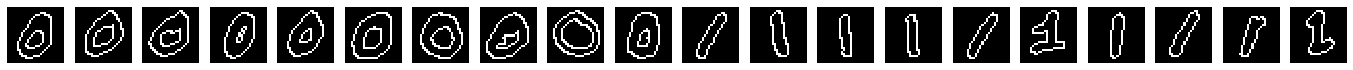

In [10]:
fig, axes = plt.subplots(1, len(images), figsize=(24, 3))

n_descriptor = 2
first_descriptor = 0

for ax, im in zip(axes, images):
    sp, contour  = dft_computation(im, n_descriptor, first_descriptor)
    ax.imshow(contour, cmap='gray')
    ax.axis('off')

#### Classify according to the two selected features

Two fourier descriptors are selected, ideally the first two as the amount of information decreased as we progress in the list of fourier descriptors computed. These descriptors are used to compute a set of samples used in the Kmeans clustering algorithms.

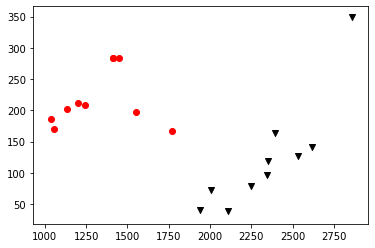

In [11]:
features = []
contours = []
images = np.append(zeros_im,ones_im,axis = 0)

n_descriptor = 2
first_descriptor = 0

for im in images:
    sp,contour = dft_computation(im, n_descriptor, first_descriptor)
    features.append(sp)
    contours.append(contour)
features = np.absolute(np.array(features))

kmeans = KMeans(n_clusters=2, random_state=0).fit(features)
kmeans.labels_
LABEL_COLOR_MAP = {0 : 'r', 1 : 'k'}
MARKER_MAP = {0 : 'v', 1: 'o', 2: '*', 3:'X'}
markers = [MARKER_MAP[i//10] for i in range(images.shape[0])]
label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]

fig, ax = plt.subplots()
for xp, yp, color, m in zip(features[:,0], features[:,1], label_color, markers):
    ax.scatter([xp],[yp],c = color, marker=m)
plt.show()

We can observe that the algorithm assigned two different labels through colors and markers to point out the difference between the two clusters we set in the function. The two clusters illustrate a necessary high extravariance and low intravariance to differentiate both family objects.

Finally, the next plot confirm that the correct labels were assigned to the correct image.

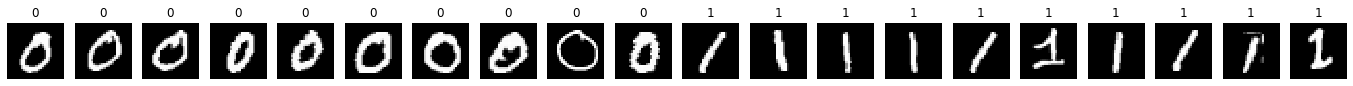

In [12]:
LABEL_NAME_MAP =  {1 : '0', 0 : '1'}
img_name = [LABEL_NAME_MAP[l] for l in kmeans.labels_]

fig, axes = plt.subplots(1, len(images), figsize=(24, 3))
for ax, im, nm in zip(axes, images, img_name):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

#### Now we are going to show the translational invariance

Having successfully separated the two set of images, we are now going to study how this method display invariant characteristics. We can start by applying a similarity transformation by shifting images throuf the y-axis. We then apply the method of fourier descriptors to clssify the images with the correct expected target labels "zero" and "one". 

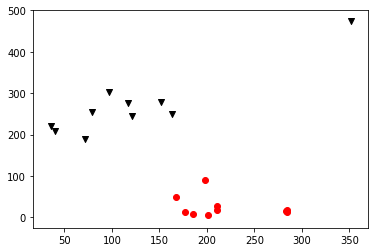

In [13]:
# Transforming images with a translation:
tform = SimilarityTransform(translation=(0, 2))

warped = []
features = []
contours = []

# add comment
for im in images:
    warped.append(warp(im, tform))
warped_translation = 255*np.array(warped)

n_descriptor = 2
first_descriptor = 1

# add comment
for im in warped_translation:
    sp,contour = dft_computation(im, n_descriptor, first_descriptor)
    features.append(sp)
    contours.append(contour)
features = np.array(features)
X = np.append(features.real,features.imag,axis=1)
features = np.absolute(features)

# add comment
kmeans = KMeans(n_clusters=2, random_state=0).fit(features)
kmeans.labels_
LABEL_COLOR_MAP = {0 : 'r', 1 : 'k'}
MARKER_MAP = {0 : 'v', 1: 'o', 2: '*', 3:'X'}
markers = [MARKER_MAP[i//10] for i in range(images.shape[0])]
label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]

fig, ax = plt.subplots()
for xp, yp, color, m in zip(features[:,0], features[:,1], label_color, markers):
    ax.scatter([xp],[yp],c = color, marker=m)
plt.show()

As expected, we can observe that the method of fourier descriptor is robust to translation transformations on images. The previous plot and the next one shows that by selecting accordingly the fourier descriptors, we can display the invariance on translation of the fourier descritpors' method. To do so, second and third fourier descriptors were selected. As seen in class, the first descriptor is sensitive to translation transformation on images and need to be avoided. 

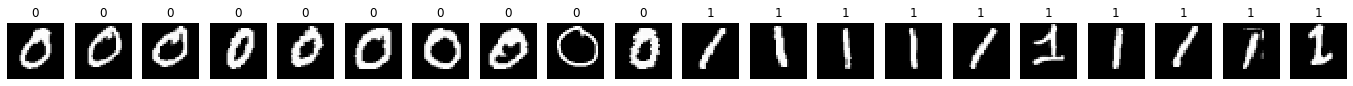

In [14]:
LABEL_NAME_MAP =  {1 : '0', 0 : '1'}
img_name = [LABEL_NAME_MAP[l] for l in kmeans.labels_]

fig, axes = plt.subplots(1, len(warped_translation), figsize=(24, 3))
for ax, im, nm in zip(axes, warped_translation, img_name):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

#### Now we are going to show the scaling invariance

In [15]:
def dft_computation_scalling(img,n_descriptor,first_descriptor):
    '''
    Compute the selected fourier descriptors in the case of scaling invariance
    
    Input: grayscale image, the number of requested fourier descriptors and the first fourier descriptor. 
    Output: The fourier descriptors divided by the first fourier descriptor and the binary contour image.
    
    '''
    uk, contour_img = complex_contour_vector(img)
    sp = np.fft.fft(uk)
    sp[1] /= sp[0]
    sp[2] /= sp[0]
    freq = np.fft.fftfreq(len(uk))
    
    return sp[first_descriptor:n_descriptor+first_descriptor],contour_img

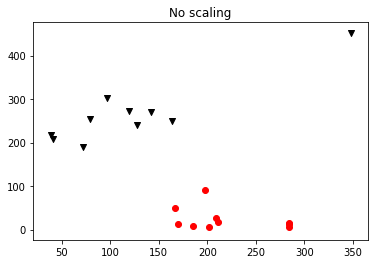

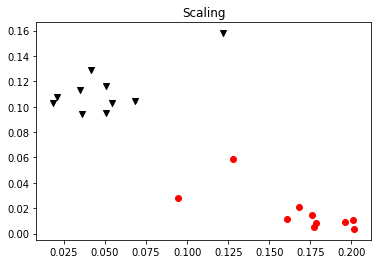

In [16]:
features = []
contours = []
features_scaling = []
contours_scaling = []
images = np.append(zeros_im,ones_im,axis = 0)

n_descriptor = 2
first_descriptor = 1

for im in images:
    sp,contour = dft_computation(im, n_descriptor, first_descriptor)
    features.append(sp)
    contours.append(contour)
features = np.array(features)
X = np.append(features.real,features.imag,axis=1)
features = np.absolute(features)

for im in images:
    sp_scaling,contour_scaling = dft_computation_scalling(im, n_descriptor, first_descriptor)
    features_scaling.append(sp_scaling)
    contours_scaling.append(contours_scaling)
features_scaling = np.array(features_scaling)
X = np.append(features_scaling.real,features.imag,axis=1)
features_scaling = np.absolute(features_scaling)

kmeans = KMeans(n_clusters=2, random_state=0).fit(features)
kmeans.labels_
LABEL_COLOR_MAP = {0 : 'r', 1 : 'k'}
MARKER_MAP = {0 : 'v', 1: 'o', 2: '*', 3:'X'}
markers = [MARKER_MAP[i//10] for i in range(images.shape[0])]
label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]

fig, ax = plt.subplots()
for xp, yp, color, m in zip(features[:,0], features[:,1], label_color, markers):
    ax.scatter([xp],[yp],c = color, marker=m)
plt.title('No scaling')
plt.show()

fig, ax = plt.subplots()
for xp, yp, color, m in zip(features_scaling[:,0], features_scaling[:,1], label_color, markers):
    ax.scatter([xp],[yp],c = color, marker=m)   
plt.title('Scaling')
plt.show()

For this experiment, we have set up the scalling transformation by divided second and third descriptor by the first one. This allows to observe a shrinkage between the two images above. Indeed, we can observe how the intra-classe variance is affected by this transformation. We can also notice that the clustering algorithm successfuly divided the two classes of objects independently of the scalling transformation. Thus, we have demonstrated the scalling invariance of this method. 

### 1.3 Additional method(s)

#### Code Chain

The first alternative method we looked at is Code Chain. Code chain is a method that associates a string of directional values to the contour of an image.

First we needed to set up a funciton that could turn the images binary. Based uppon the histogram of the first zero given in our list, we chose to start our binary threshold at a value of 100. This would leave only purely white and black pixels.

Then we need to find the first pixel of the image number and start the algorithme that creates the string. We used the Freeman algorithm to do this with some simple algebriac trics to make sure we always start by checking the inside of the number for it's border.

In [17]:
def binaryImage(im):
    '''
    Threshold function that returns values of 0 or 255 if image pixel values are within thresholds
    
    Input: image
    Output: 0 or 255 'binary' image
    '''
    im_filt = low_pass_filter(im,3)
    im_binary = cv2.inRange(im_filt,100,255) #threshold values found from 
    return im_binary

In [18]:
def freemanStart(im):
    '''
    Simple number start detection function
    Scans image rows and columns until it finds logical pixel value of 1
    
    Input: binarized image
    Output: pixel position one step to the left of first pixel belonging to the number
    '''
    for i, row in enumerate(im):
        for j, value in enumerate(row):
            if value == 255:
                startPoint = (i, j-1) #-1 to make sure the start point is part of the contour points chain
                return startPoint
            else : continue

In [19]:
def freemanString(im):
    '''
    Function detecting the the edge of an image and contourning the border following Freeman directional values
    Freeman direction values:
    | 3 2 1 |
    | 4 X 0 |
    | 5 6 7 |
    
    Input: Binarized image
    Output: Pixel positions of the number contour, freeman chain direction values
    '''
    dir_code = [0,1,2,3,4,5,6,7]
    next_i   = [0,-1,-1,-1,0,1,1,1] #rows
    next_j   = [1,1,0,-1,-1,-1,0,1] #columns
    
    
    start_point = freemanStart(im)
    curr_point  = start_point
    contour = []
    chain = []

    for direction in dir_code:
        next_point = (curr_point[0]+next_i[direction],curr_point[1]+next_j[direction])
        if im[next_point] != 255:
            contour.append(next_point)
            chain.append(direction)
            curr_point = next_point
            break

    last = 0
    while 1:
        if curr_point == start_point: last = 1
        #choose search starting direction to always rotate clockwise
        start_dir = (direction + 5) % 8
        dir1 = range(start_dir, 8)
        dir2 = range(0, start_dir)
        dirc = []
        dirc.extend(dir1)
        dirc.extend(dir2)
        for direction in dirc:
            next_point = (curr_point[0]+next_i[direction],curr_point[1]+next_j[direction])
            if im[next_point] != 255:
                contour.append(next_point)
                chain.append(direction)
                curr_point = next_point
                break
        if last == 1 : break
            
    return contour,chain

Example chain code string for image 5 of ones and plotted contour on binary number: 

[1, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 7, 6, 6, 5, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 5, 4, 4, 3, 2, 2, 1, 0, 1, 0, 0, 1, 7, 1, 2, 2, 2, 2, 3, 4, 5, 4, 4, 4, 3, 2, 1, 0, 0, 1, 1, 1, 2, 1, 2, 1, 1]


(-0.5, 27.5, 27.5, -0.5)

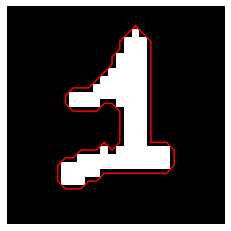

In [27]:
im_test = binaryImage(ones_im[5])
contour,chain = freemanString(im_test)
print('Example chain code string for image 5 of ones and plotted contour on binary number: \n')
print(chain)
plt.imshow(im_test,cmap='gray')
plt.plot([i[1] for i in contour], [i[0] for i in contour],'r')
plt.axis('off')

In this example, we can see the binary version of the 5th number 'one' and it's contour as detected by our Freeman algorithm. As we can see, it sticks pretty well to the visual contour. We will check bellow all the other numbers to make sure there aren't any problems.

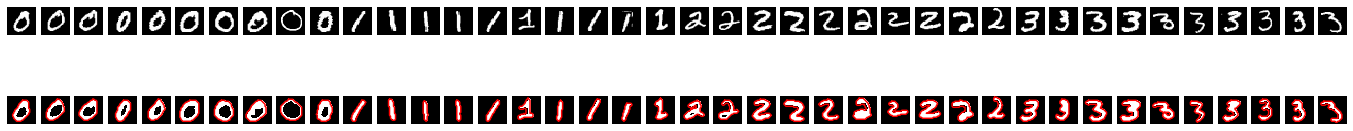

In [28]:
fig, axes = plt.subplots(2, len(images), figsize=(24, 3))
for ax, im in zip(axes[0], images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    
for ax, im in zip(axes[1], images):
    im_free = binaryImage(im)
    ax.imshow(im_free, cmap='gray')
    contour,chain = freemanString(im_free)
    ax.plot([i[1] for i in contour], [i[0] for i in contour],'r')
    ax.axis('off')

In [29]:
# here we choose the two "typical" chain based on how the images appear to be closest to a "basic" or "normal" one and zero
chain_typ_one  = freemanString(binaryImage(ones_im[3]))
chain_typ_zero = freemanString(binaryImage(zeros_im[6]))

To continue, we implimented the Fisher Wagner algorithm to obtain the edition distance of a given number chain code to a known "typical" chain code of one of the numbers. We chose our typical chains based on how easily they are visually identidfied. the one image number 3 and the yero image number 6 seem to be two good candidates for this purpose.

In [30]:
def delta(x,y):
    '''
    Simple function that determines if values are equal or not
    
    Input: two values x and y
    Output: 1 or 0
    '''
    if x == y: return 0
    else : return 1

def FW_algorithm(tst_str, trg_str):
    '''
    Fisher-Wagner edition distance algorithm
    
    Input: test Freeman string, target Freeman string
    Output: edition distance from test to target strings
    '''
    D = np.zeros((len(tst_str), len(trg_str)))
    D[0][0] = 0
    D[0][1] = 1
    D[1][1] = 0
    D[1][0] = 1
    for m in range(len(tst_str)-1):
        for n in range(len(trg_str)-1):
            opt_1 = D[m][n] + delta(tst_str[m+1],trg_str[n+1])
            opt_2 = D[m][n+1] + 1
            opt_3 = D[m+1][n] + 1
            D[m+1][n+1] = min(opt_1, opt_2, opt_3)

    distance = D[len(tst_str)-1][len(trg_str)-1]
    
    return distance

In [31]:
distFW_0 = []
distFW_1 = []
lengthFC = []

for im in images:
    im_free = binaryImage(im)
    contour,chain = freemanString(im_free)
    dist_zero = FW_algorithm(chain, chain_typ_zero[1])
    dist_one = FW_algorithm(chain, chain_typ_one[1])
    length = len(chain)
    distFW_0.append(dist_zero)
    distFW_1.append(dist_one)
    lengthFC.append(length)

features_cc = []
features_cc.append(distFW_0)
features_cc.append(distFW_1)
features_cc.append(lengthFC)

Text(0.5, 0, 'number ID')

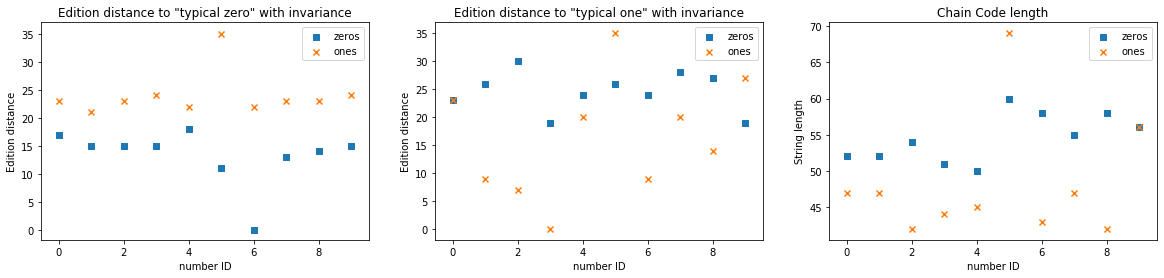

In [32]:
idx = range(10) 
f, ax = plt.subplots(1, 3, figsize=(20,4))
ax[0].scatter(idx, features_cc[0][0:10], marker = 's', label='zeros')
ax[0].scatter(idx, features_cc[0][10:20], marker = 'x',label='ones')
ax[0].legend()
ax[0].set_title('Edition distance to "typical zero" with invariance')
ax[0].set_ylabel('Edition distance')
ax[0].set_xlabel('number ID')

ax[1].scatter(idx, features_cc[1][0:10], marker = 's', label='zeros')
ax[1].scatter(idx, features_cc[1][10:20], marker = 'x',label='ones')
ax[1].legend()
ax[1].set_title('Edition distance to "typical one" with invariance')
ax[1].set_ylabel('Edition distance')
ax[1].set_xlabel('number ID')

ax[2].scatter(idx, features_cc[2][0:10], marker = 's', label='zeros')
ax[2].scatter(idx, features_cc[2][10:20], marker = 'x',label='ones')
ax[2].legend()
ax[2].set_title('Chain Code length')
ax[2].set_ylabel('String length')
ax[2].set_xlabel('number ID')

We tried to class our numbers according to three criterias : the edition distance to our typical zero, to our typical one and the length of the code string as they seemed to consistently be different for the two numbers.

As we can see above, the edition distance to the typical zero seems to be a good indicator. We have low variance within a number class, so the are fairly identifiable, but also low variance between classes which could be improvec. We are however able to draw a line between the ones and zeros at about a distance of 20.

The edition distance to the typical one however is all over the place and does not seem to offer much usefull information. There are however some low values for the ones that were in the same axe as our typical one, so some rotational transformation would be usefull to sort things out. We will see this later.

Although the length of the chains seemed pretty far fetched as a criteria, we can see a pattern appear with the ones below fifty and the zeros above.

In all our graphs we can notice a few exception that do not obay to the rules. notably is one number 5, who has a much more complexe contour compaired to the other numbers, and one number 9 who shares the same kind of writing as number 5.

#### Distance Between Contours using Chamfer's algorithm 

The second axtra method we tried is to compare the distance between contours using Chamfer's algorithm. We simply followed the algorithm as it was explained in class and also put into place our own rotation and translation function to study the effect of those elements.

In [33]:
def ChamferDistanceMap(im):
    '''
    Function providing the distance map of a sigle image to be used for image distace similarity checks
    Chamfer distance values around one point:

    | 4 3 4 |
    | 3 0 3 |
    | 4 3 4 |

    Input: Binarized image
    Output: Chamfer Distance Map of image
    '''
    rows = len(im)
    columns = len(im[0])   
    CDM = np.zeros((rows,columns))
    
    #initial pass on image
    for i in range(0,rows):
        for j in range(0,columns):
            if  im[i][j] == 255:
                CDM[i][j] = 0
            else : CDM[i][j] = 1000    #large value used instead of infinity
                    
    #Direct pass
    for i in range(0,rows-1):
        for j in range(0,columns-1):
            opt_1 = CDM[i-1][j-1]+4
            opt_2 = CDM[i-1][j]+3
            opt_3 = CDM[i-1][j+1]+4
            opt_4 = CDM[i][j-1]+3
            opt_5 = CDM[i][j]
            CDM[i][j]=min(opt_1, opt_2, opt_3, opt_4, opt_5)
    
    #Inverse pass
    for i in reversed(range(-1,rows-1,)):
        for j in reversed(range(-1,columns-1)):
            opt_1 = CDM[i][j+1]+3
            opt_2 = CDM[i+1][j-1]+4
            opt_3 = CDM[i+1][j]+3
            opt_4 = CDM[i+1][j+1]+4
            opt_5 = CDM[i][j]
            CDM[i][j]=min(opt_1, opt_2, opt_3, opt_4, opt_5)
    
    return CDM

In [34]:
import math
def contourDistance(im,CDM):
    '''
    Simple distance calculation function. Scans input image coordiantes.
    Compares object coordinates to pre-calculated Distance Map of target.
    
    Input: binarized image of input, Chamfer Distance Map of target
    Output: Distance between contours
    '''
    sumDist = 0
    distance = 1000   #max value to avoid NaNs
    n = 0
    for i, row in enumerate(im):
        for j, value in enumerate(row):
            if value == 255:
                sumDist = sumDist + CDM[i][j]**2
                n += 1
            else : continue
    if n > 0:
        distance = math.sqrt(sumDist / n)
        return distance

In [35]:
def transfRot(im,CDM):
    '''
    Function that finds the optimal rotation angle value for the minimal contour distance
    
    Input: original image and chamfer Distance Map of taget image
    Output: minimal contour distance and rotation angle
    '''
    min_dist = contourDistance(im,CDM) 
    rot_angle = 0
    for angle in range(0,360):
        im_rot = skimage.transform.rotate(im, angle)*255 #x255 necessary as skimage returns value between 0 and 1
        dist = contourDistance(im_rot,CDM)
        if dist < min_dist:
            min_dist = dist
            rot_angle = angle
    return min_dist, rot_angle

In [36]:
# Translation
def transfTrans(im,CDM):
    '''
    Function that finds the optimal translation x and y values for the minimal contour distance
    
    Input: Original image and chamfer Distance Map of taget image
    Output: Minimal contour distance and x and y translation values
    '''
    nrows, ncols = im.shape[:2] 
    x_trans = 0
    y_trans = 0
    min_dist = contourDistance(im,CDM)
    scan_range = len(im)
    for i in range(-scan_range//4,scan_range//4): #translation scan is between -7 and +7 as image only 28 pixels wide
        for j in range(-scan_range//4,scan_range//4): # and because the numbers are usualy already pretty well centered
            translation_matrix = np.float32([ [1,0,i], [0,1,j] ])
            im_trans = cv2.warpAffine(im, translation_matrix, (ncols, nrows))
            dist = contourDistance(im_trans,CDM)
            if dist < min_dist:
                min_dist = dist
                x_trans = i
                y_trans = j
    return min_dist, x_trans, y_trans

In [37]:
def contDistTransf(im,CDM):
    '''
    Funciton that tests both Translation and Rotation transformations to find which one has the 
    smaller contour distance
    then applies the second transformation to try and minimise the distance further.
    
    Input: Original image and chamfer Distance Map of taget image
    Output: Minimal contour distance, rotation angle and x and y translation values
    '''
    nrows, ncols = im.shape[:2]
    dist_t,x_t,y_t = transfTrans(im, CDM)
    dist_r, a_r = transfRot(im, CDM)
    if dist_t <= dist_r :
        translation_matrix = np.float32([ [1,0,x_t], [0,1,y_t] ])
        im_t = cv2.warpAffine(im, translation_matrix, (ncols, nrows))
        distance, angle = transfRot(im_t, CDM)
        x = x_t
        y = y_t
    else : 
        im_r = skimage.transform.rotate(im, a_r)*255 # x255 needed as skimage return value between 0 and 1
        distance, x, y = transfTrans(im_r, CDM)
        angle = a_r
    return distance, angle, x, y
        

In [38]:
#here we choose the two "typical" number one and zero to act as the reference Chamfer Distance Map for our analysis
CDM_zero = ChamferDistanceMap(binaryImage(zeros_im[6]))
CDM_one  = ChamferDistanceMap(binaryImage(ones_im[3]))

Here again, we needed to choose two "typical" examples of ones and zeros. For the sake of continuity, we stuck with our choices of zero 6 and one 3.

These are very heavy computations as they require us to go over the images several times during our calculations, for each rotation and each translation.

In [39]:
transf_zero_compare = []
dist_cd_0 = []
features_cd = []

for im in images:
    im_cd = binaryImage(im)
    data_zero = contDistTransf(im_cd,CDM_zero)
    transf_zero_compare.append(data_zero[1:4])
    dist_cd_0.append(data_zero[0])
features_cd.append(dist_cd_0)

In [40]:
transf_one_compare = []
dist_cd_1 = []
for im in images:
    im_cd = binaryImage(im)
    data_one = contDistTransf(im_cd,CDM_one)
    transf_one_compare.append(data_one[1:4])
    dist_cd_1.append(data_one[0])
features_cd.append(dist_cd_1)

Text(0, 0.5, 'number ID')

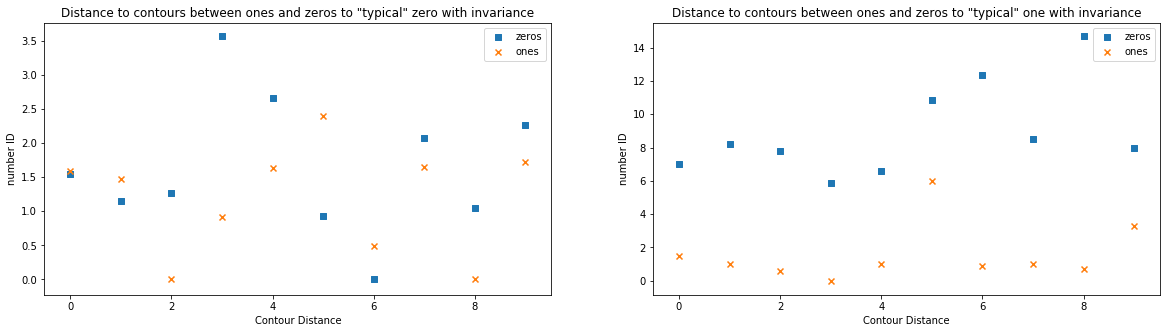

In [41]:
f, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].scatter(idx, features_cd[0][0:10], marker = 's', label='zeros')
ax[0].scatter(idx, features_cd[0][10:20], marker = 'x',label='ones')
ax[0].legend()
ax[0].set_title('Distance to contours between ones and zeros to "typical" zero with invariance')
ax[0].set_xlabel('Contour Distance')
ax[0].set_ylabel('number ID')

ax[1].scatter(idx, features_cd[1][0:10], marker = 's', label='zeros')
ax[1].scatter(idx, features_cd[1][10:20], marker = 'x',label='ones')
ax[1].legend()
ax[1].set_title('Distance to contours between ones and zeros to "typical" one with invariance')
ax[1].set_xlabel('Contour Distance')
ax[1].set_ylabel('number ID')

As we can see here above, the contour distance between the numbers and the typical zero seem very independent from the value of the number. We suspect this is because the thin contour of a one is almost always included in that of a zero, resulting in a very low average. 

As we look at the contour distance to the typical one however, we will find a clear distinctions between both numbers, with all the zeros being systematically above or equal to about 6. This is a good identification criteria.

#### Chain Code with invariance of Rotation and Translation

Since we devolopped these rotation and translation functions, we decided to try and use the optimal transformation calculated for contour distancing and see if it would improve our results of edition distance using chain code.
We simply needed to write a function that would apply the optimal transformations to our images.

In [42]:
def imageTransform(im,angle, x_t, y_t):
    '''
    Function that takes computed optimal rotation and translation values for contour distance 
    and returns the transformed image
    
    Input: Original image, rotation angle and translation x and y values
    Output: Transformed image with desired rotation and translation
    '''
    im_rot = skimage.transform.rotate(im, angle)
    nrows, ncols = im.shape[:2] 
    translation_matrix = np.float32([ [1,0,x_t], [0,1,y_t] ])
    im_transf = cv2.warpAffine(im_rot, translation_matrix, (ncols, nrows))
    return im_transf

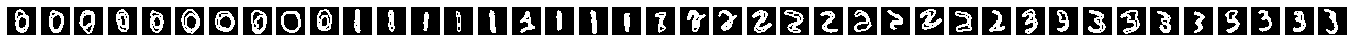

In [55]:
# Image plot to view result of number transformation by rotation and translation, then turned to binary values
i = 0
fig, axes = plt.subplots(1, len(images), figsize=(24, 3))
for ax, im in zip(axes, images):
    im_bin = binaryImage(im)
    trsf_data = transf_one_compare[i][:]
    im_trsf = imageTransform(im_bin, trsf_data[0], trsf_data[1], trsf_data[2])*255 
    im_show = binaryImage(im_trsf)
    ax.imshow(im_show, cmap='gray')
    ax.axis('off')
    i += 1 

In order to use our function, we needed a binary "0" and "255" coding of our images. As we can see here in the transformed images, we were lucky we did not exceed the boarders. There is definetly room for improvement here, but it should be enough to see if the transformations had an effect.

In [44]:
distFW_0 = []
distFW_1 = []
lengthFC = []
i = 0

for im in images:
    im_free = binaryImage(im)
    trsf_data = transf_zero_compare[i][:]
    im_trsf = imageTransform(im_free, trsf_data[0], trsf_data[1], trsf_data[2])*255
    contour,chain = freemanString(binaryImage(im_trsf))
    dist_zero = FW_algorithm(chain, chain_typ_zero[1])
    length = len(chain)
    distFW_0.append(dist_zero)
    lengthFC.append(length)
    i += 1

i = 0
for im in images:
    im_free = binaryImage(im)
    trsf_data = transf_one_compare[i][:]
    im_trsf = imageTransform(im_free, trsf_data[0], trsf_data[1], trsf_data[2])*255
    contour,chain = freemanString(binaryImage(im_trsf))
    dist_one = FW_algorithm(chain, chain_typ_one[1])
    distFW_1.append(dist_one)
    i += 1

features_cc2 = []
features_cc2.append(distFW_0)
features_cc2.append(distFW_1)
features_cc2.append(lengthFC)

Text(0.5, 0, 'number ID')

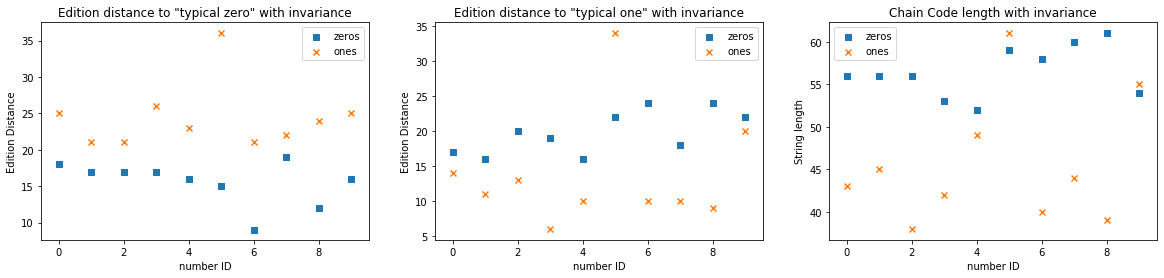

In [45]:
idx_zeros = range(10) 
idx_ones = range(10,20)
f, ax = plt.subplots(1, 3, figsize=(20,4))
ax[0].scatter(idx_zeros, features_cc2[0][0:10], marker = 's', label='zeros')
ax[0].scatter(idx_zeros, features_cc2[0][10:20], marker = 'x',label='ones')
ax[0].legend()
ax[0].set_title('Edition distance to "typical zero" with invariance')
ax[0].set_ylabel('Edition Distance')
ax[0].set_xlabel('number ID')

ax[1].scatter(idx_zeros, features_cc2[1][0:10], marker = 's', label='zeros')
ax[1].scatter(idx_zeros, features_cc2[1][10:20], marker = 'x',label='ones')
ax[1].legend()
ax[1].set_title('Edition distance to "typical one" with invariance')
ax[1].set_ylabel('Edition Distance')
ax[1].set_xlabel('number ID')

ax[2].scatter(idx_zeros, features_cc2[2][0:10], marker = 's', label='zeros')
ax[2].scatter(idx_zeros, features_cc2[2][10:20], marker = 'x',label='ones')
ax[2].legend()
ax[2].set_title('Chain Code length with invariance')
ax[2].set_ylabel('String length')
ax[2].set_xlabel('number ID')

As we can see above, the edition distance to zeros and the chain code length still remain good conditions do identify our numbers. But we know also have a better identification for the edition distance to our typical one. This proves that our hypothesis of before was correct and that the rotations of the tilted ones had a big effect on their identification.

For both edition distances, we have low number class variance and a distinct threshold value that allows us to differentiate them, respectivaly about 20 and about 15, and demonstrates that if we pushed this method even further, it could be a very good method for class indentification.

#### Compacity 

We have selected to study another contour-based method of the image. The compacity of the image has been implemented with the help of the area A2 and perimeter P2 as presented in class. 

In [46]:
import cv2
import math

def get_pixel(im):
    '''
    Compute a list of all coordinates of an image
    
    Input: grayscale image
    Output: list of all coordinates of a grayscale image
    
    '''
    im_filtered = low_pass_filter(im,3)
    coordinate = []
    
    row,col = im_filtered.shape
    for r in range(row):
        for c in range(col):
            coordinate.append((r,c))
    return coordinate

def is_inside_contour(contour, non_zero_pixels):
    '''
    Check wether a point is inside of a contour and return the number of point within a contour
    
    Input: a list of pixel coordinates and a list of contour coordinates
    Output: number of point within a contour
    
    '''
    counter = 0
    for coord in non_zero_pixels:
        dist = cv2.pointPolygonTest(contour,coord,True)
        if dist > 0:
            counter += 1
    return counter

def compute_perimeter(contour_list):
    '''
    Compute the perimeter of a shape based on its contour
    
    Input: a list of contour coordinates 
    Output: perimeter 
    
    '''
    coord_tmp = []
    counter = 0
    nearby_point = 0
    for coord in contour_list:
        coord_tmp.append(coord)
        if counter != 0:
            if (coord_tmp[0][0] == coord_tmp[1][0]) or (coord_tmp[0][1] == coord_tmp[1][1]):
                nearby_point += 1
            coord_tmp.pop(0)
        counter += 1
    p_2 = (len(contour_list) - nearby_point)*math.sqrt(2) + nearby_point - 1
    return p_2

In [47]:
images = np.append(zeros_im,ones_im,axis = 0)

compacity_zeros = []
compacity_ones = []
area_zeros = []
area_ones = []
perimeter_zeros = []
perimeter_ones = []

counter = 0

for im in images:
    contour = get_ordered_contour(im) 
    region_coord = get_pixel(im)
    contour_list = contour.tolist()
    
    # Computing Area A_32
    i = is_inside_contour(contour, region_coord)
    b = len(contour)
    area_tmp = (b/2 + i-1)
    if counter < 10:
        area_zeros.append(area_tmp)
    else:
        area_ones.append(area_tmp)
    
    # Computing perimeter P_3
    perimeter_tmp = compute_perimeter(contour_list)
    if counter < 10:
        perimeter_zeros.append(perimeter_tmp)
    else:
        perimeter_ones.append(perimeter_tmp)
    
    # Computing compacity
    compacity_tmp = perimeter_tmp**2/area_tmp
    if counter < 10:
        compacity_zeros.append(compacity_tmp)
    else:
        compacity_ones.append(compacity_tmp)
    
    counter += 1


Text(0, 0.5, 'compacity')

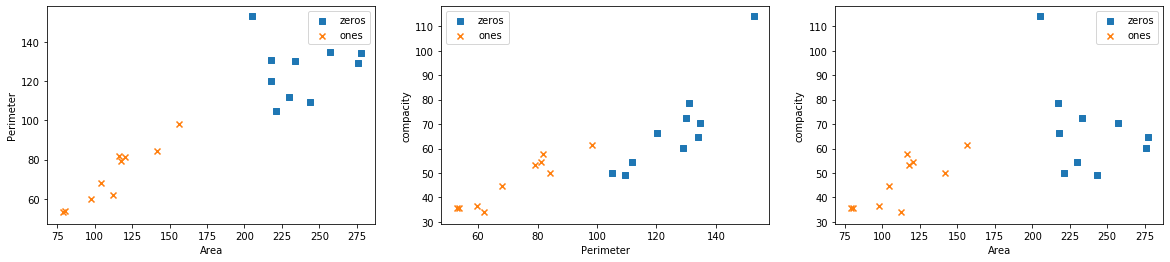

In [48]:
f, ax = plt.subplots(1, 3, figsize=(20,4))
ax[0].scatter(area_zeros, perimeter_zeros, marker = 's', label='zeros')
ax[0].scatter(area_ones, perimeter_ones, marker = 'x',label='ones')
ax[0].legend()
ax[0].set_xlabel('Area')
ax[0].set_ylabel('Perimeter')

ax[1].scatter(perimeter_zeros, compacity_zeros, marker = 's', label='zeros')
ax[1].scatter(perimeter_ones, compacity_ones, marker = 'x', label='ones')
ax[1].legend()
ax[1].set_xlabel('Perimeter')
ax[1].set_ylabel('compacity')

ax[2].scatter(area_zeros, compacity_zeros, marker = 's', label='zeros')
ax[2].scatter(area_ones, compacity_ones, marker = 'x', label='ones')
ax[2].legend()
ax[2].set_xlabel('Area')
ax[2].set_ylabel('compacity')

We have displayed three graphs where we've plotted separately the zero and ones images by taking into account the perimeters, area and compacity. We can observe that in all the case, it would be possible to create two clusters but the method that would require the least effort for a clustering algorithm as Kmeans, would be the first case. In that case, we rely on the perimeter and area of the images. We can observe both good intra-class et extra-class variance requirements to obtains two separates clusters. We can observe that by introducing the compacity, the extra-class variance tend to decrease as shown in the plot in the middle while the intra-class variance tend to increase in the two plots with compacity. 

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

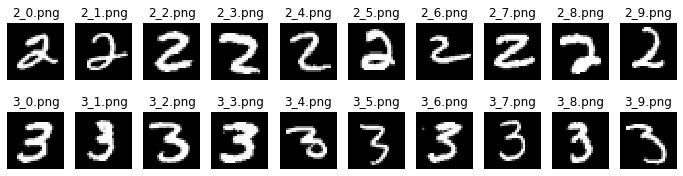

In [49]:
#  Load twos
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load threes
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Additional method(s) and conclusion

In the first part, we have successfully constructed two clusters with the help of the method of Fourier descriptors in a space based with two dimensions (two descriptors). We are going to observe if it is possible to repeat the experiment by adding two new class of objects formed of additional images of hand-written "two" and "three". 

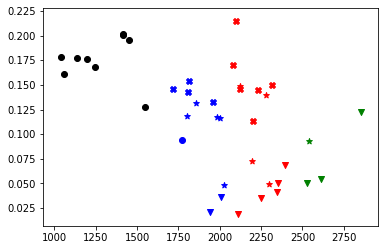

In [52]:
features = []
contours = []
images = np.append(zeros_im,ones_im,axis = 0)
images = np.append(images,twos_im,axis = 0)
images = np.append(images,threes_im,axis = 0)

n_descriptor = 2
first_descriptor = 0

for im in images:
    sp,contour = dft_computation_scalling(im, n_descriptor, first_descriptor)
    features.append(sp)
    contours.append(contour)
features = np.array(features)
X = np.append(features.real,features.imag,axis=1)
features = np.absolute(features)

kmeans = KMeans(n_clusters=4, random_state=0).fit(features)
kmeans.labels_
LABEL_COLOR_MAP = {0 : 'r', 1 : 'k', 2: 'b', 3: 'g'}
LABEL_NAME_MAP =  {0 : '1', 1 : '0', 2 : 'Outlier', 3 : '2/3'}
MARKER_MAP = {0 : 'v', 1: 'o', 2: '*', 3:'X'}
markers = [MARKER_MAP[i//10] for i in range(images.shape[0])]
label_color = [LABEL_COLOR_MAP[l] for l in kmeans.labels_]

fig, ax = plt.subplots()
for xp, yp, color, m in zip(features[:,0], features[:,1], label_color, markers):
    ax.scatter([xp],[yp],c = color, marker=m)
plt.show()

We can observe that the clustering algorithm isn't able to perform a successful clustering of the four different objects. Indeed, we can observe four distinctive colors but cluster red, green and black are formed of different markers. The expected result would have been to have four clusters displaying a specific color and marker each. One way to get rid of this issue would be to use a larger set of descriptors and images of each category. The next plot shows the incapacity for the Kmeans algorithm to successfully affect labels to the images.

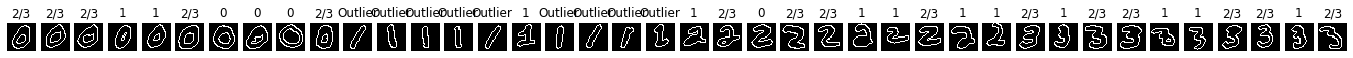

In [25]:
img_name = [LABEL_NAME_MAP[l] for l in kmeans.labels_]

fig, axes = plt.subplots(1, len(images), figsize=(24, 3))

for ax, im, nm in zip(axes, contours, img_name):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)